In [1]:
import os
from PIL import Image

In [2]:
# download datatset of faces
# if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
#     !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz

In [3]:
image_paths = os.listdir('testset')

train_image_paths = []
test_image_paths = []

num = 3

i=0
while len(train_image_paths) < num:
    i+=1
    # i into 3 digit number
    if i < 10:
        filename = f'image_000{i}'
    elif i < 100:
        filename = f'image_00{i}'
    else:
        filename = f'image_0{i}'

    if filename+'.png' not in image_paths:
        continue
    
    train_image_paths.append(os.path.join('testset', filename+'.png'))
    test_image_paths.append(os.path.join('testset', filename+'_mirror.jpg'))

In [4]:
len(train_image_paths), len(test_image_paths)

(3, 3)

In [5]:
train_image_paths[:5], test_image_paths[:5]

(['testset/image_0001.png',
  'testset/image_0002.png',
  'testset/image_0003.png'],
 ['testset/image_0001_mirror.jpg',
  'testset/image_0002_mirror.jpg',
  'testset/image_0003_mirror.jpg'])

In [6]:
from facial_detection.facial_detection import FacialDetection

facial_detection = FacialDetection()

/Users/andrewjenkins/anaconda3/envs/intelligent_sn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# facial embeddings -> image file name
from tqdm import tqdm


train_data = {}
ground_truth = {}
train_embeddings = []
test_embeddings = []

for train_path, test_path in tqdm(zip(train_image_paths, test_image_paths)):
    train_image = Image.open(train_path).convert('RGB')
    test_image = Image.open(test_path).convert('RGB')

    detected_face = facial_detection.detect_face(train_image)

    embedding = facial_detection.get_facial_embeddings(detected_face)

    train_embeddings.append(embedding)
    train_data[embedding] = train_path.split('/')[-1]

    detected_face = facial_detection.detect_face(test_image)
    embedding = facial_detection.get_facial_embeddings(detected_face)
    test_embeddings.append(embedding)
    ground_truth[embedding] = train_path.split('/')[-1]


3it [00:02,  1.29it/s]


In [8]:
ground_truth[test_embeddings[0]], train_data[train_embeddings[0]]

('image_0001.png', 'image_0001.png')

In [9]:
from database.db import Database
import time

# dist -> searchmethod -> (speed, accuracy)
collected_metrics = {}

# collect speed and accuracy for each search method
for dist_func in ['l2_squared','cosine']:
    collected_metrics[dist_func] = {}
    for search_method in ['lsh','hnsw','linear', 'vector_compression']:
        print('Dist:',dist_func, 'Search:',search_method)

        db = Database(search_method, dist_func)

        for embedding in train_embeddings:
            db.add_entry(embedding.numpy().reshape(-1), train_data[embedding])

        correct = 0
        start_time = time.time()
        for embedding in test_embeddings:
            result = db.query_entry(embedding.numpy().reshape(-1))

            if result == ground_truth[embedding]:
                correct+=1

        end_time = time.time()
        collected_metrics[dist_func][search_method]= (len(test_embeddings)/(end_time-start_time), correct/len(test_embeddings))


Dist: l2_squared Search: lsh
Dist: l2_squared Search: hnsw
Dist: l2_squared Search: linear
Dist: l2_squared Search: vector_compression
(3, 32) (32,)


IndexError: index 28 is out of bounds for axis 0 with size 3

In [ ]:
collected_metrics

{'l2_squared': {'lsh': (2433.3002651258043, 0.955),
  'hnsw': (14294.053096138772, 0.97),
  'linear': (302.4891523958123, 0.97)},
 'cosine': {'lsh': (2312.8864870826324, 0.91),
  'hnsw': (10691.300247253448, 0.97),
  'linear': (143.2395752438209, 0.97)}}

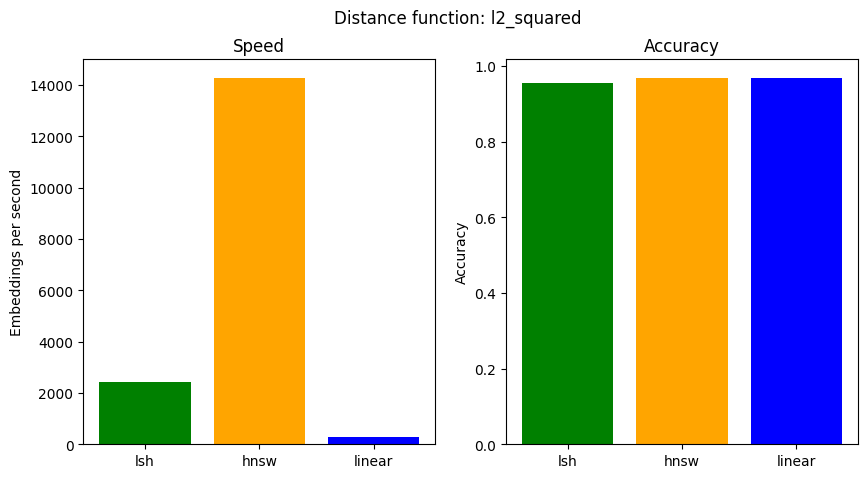

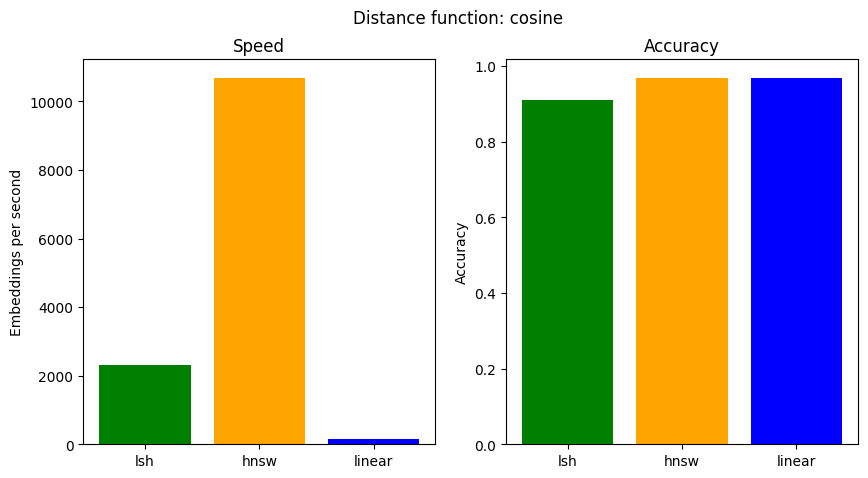

In [ ]:
# make 2 1x2 bar plots for each metric for each dist_func, different colors for each search method

import matplotlib.pyplot as plt
colors = ['green','orange','blue']

for dist_func in collected_metrics.keys():
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'Distance function: {dist_func}')
    for i, search_method in enumerate(collected_metrics[dist_func].keys()):
        axs[0].bar(search_method, collected_metrics[dist_func][search_method][0], color=colors[i], label=search_method)
        axs[1].bar(search_method, collected_metrics[dist_func][search_method][1], color=colors[i], label=search_method)

    axs[0].set_title('Speed')
    axs[0].set_ylabel('Embeddings per second')
    axs[1].set_title('Accuracy')
    axs[1].set_ylabel('Accuracy')

    plt.show()
